# Genodesic Tutorial on the Schiebinger Dataset

This notebook demonstrates the end-to-end **Genodesic** pipeline for trajectory reconstruction. Our goal is to find a biologically meaningful path between two cell states in the Schiebinger dataset. We achieve this by computing a geodesic with respect to a data-density-aware Fermat metric, which ensures the path realistically follows the underlying data manifold.

The analysis is broken down into four key stages:

1.  **Data Preparation:** We begin by downloading the dataset, selecting the most informative Highly Variable Genes (HVGs), and training an autoencoder to project the high-dimensional count data into a more manageable latent space. This creates the space where our analysis will take place.

2.  **Score-Based Density Modeling:** We then train the core of our method, a VP-SDE model, on this latent space. This model learns the data's score field ($s = \nabla_x \log p$), which is the essential gradient information used to guide the pathfinding process.

3.  **Geodesic Computation:** With the score model in hand, we select start and end cells from different timepoints. We find an initial path proposal using a density-aware graph search and then iteratively refine this guess into a smooth geodesic using our learned score function.

4.  **Analysis & Validation:** Finally, we evaluate the properties of our initial and refined paths. We will analyze their length and density profiles and, most importantly, compare their progression against the dataset's known "wall-clock time" to validate the biological plausibility of our reconstructed trajectory.

## Global Notebook Configuration

This section contains all the key parameters for the entire pipeline. It's the main control panel for this notebook.

**Default Parameters & Overrides:**
The Genodesic package uses YAML files (`Config/models.yaml` and `Config/refinement.yaml`) to store default hyperparameters for training and path refinement. Below, we define Python dictionaries that override these defaults for specific experiments.

In [1]:
import os
import torch

# --- A. Global Toggles & Setup ---
ReextractHVGs = False
RetrainAutoencoder = False
RetrainDensity = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- B. Define Core Parameters ---
TRUNK = "both"
N_HVG = 2000
BOTTLENECK_DIM = 24
MODEL_TYPE = "vpsde"  # Options: "vpsde", "otcfm", "rqnsf"

# --- C. Dynamically Generate All File Paths ---
hvg_output_file = f"schiebinger_hvg_tensor_trunk-{TRUNK}_{N_HVG}hvg.pt"
hvg_tensor_path = os.path.join("Pipeline/HVGs", hvg_output_file)

ae_model_save_path = f"Models/Autoencoder/trunk-{TRUNK}_dim-{BOTTLENECK_DIM}_hvg-{N_HVG}.pt"
latent_save_path = f"LatentSpace/trunk-{TRUNK}_dim-{BOTTLENECK_DIM}_hvg-{N_HVG}_latent.pt"
density_model_save_path = f"Models/DensityModels/{MODEL_TYPE}_trunk-{TRUNK}_dim-{BOTTLENECK_DIM}.pt"

# --- D. Define All Overrides 
notebook_overrides = {
    "hvg_extraction": {
        "output_file": hvg_output_file,
        "trunk": TRUNK,
        "n_hvg": N_HVG,
        "min_counts": 2000,
        "max_counts": 50000,
        "min_cells": 50,
    },
    "autoencoder": {
        "model_save_path": ae_model_save_path,
        "latent_save_path": latent_save_path,
        "bottleneck_dim": BOTTLENECK_DIM,
        "num_epochs": 50,
        "learning_rate": 0.0005,
    },

    "density_model": {
        "model_type": MODEL_TYPE,
        "data_file": latent_save_path,
        "model_save_path": density_model_save_path,
        "dim": BOTTLENECK_DIM,
        "num_epochs": 10,
        "batch_size": 512,
    }
}

# 0: Downloading the Schiebinger Dataset

We first download and extract the Schiebinger Dataset. As this can be a bit tricky, we provide a shell script that automatically downloads the entire dataset and extracts it to Data/Schiebinger. If a dataset is already found at that path, the download is skipped.

In [ ]:
%%bash
Pipeline/SchiebingerDownload.sh

--- Schiebinger Dataset Downloader ---
Directory Data/Schiebinger already exists and is not empty.
Continuing: will attempt to extract/unpack any archives found in this directory.
Skipping cleanup as no new download was performed.
---
Dataset is located in: Data/Schiebinger


# 1: Extracting HVGs of chosen Branch

We now combine all datasets and filter for the desired branch. Afterwards we run HVG extraction and save the new combined HVG count matrix to disk. Per default the extraction is skipped if the count matrix already exists. The boolean `ReextractHVGs` overwrites this check. 


In [3]:
from Genodesic.Utils import load_config
from Pipeline.firstSelectHVGs import run_hvg_extraction
import matplotlib.pyplot as plt

if os.path.exists(hvg_tensor_path) and not ReextractHVGs:
    print(f"File {hvg_output_file} already exists. Skipping.")
else:
    print("Starting HVG extraction...")
    hvg_config = load_config(
        default_config_path='Config/hvg_extraction.yaml',
        overrides=notebook_overrides
    )
    hvg_fig = run_hvg_extraction(
        config=hvg_config,
        data_dir="Data/Schiebinger",
        debug=True
    )
    if hvg_fig: plt.show()

File schiebinger_hvg_tensor_trunk-both_2000hvg.pt already exists. Skipping.


# 2: Training the Autoencoder

In [4]:
from Pipeline.secondTrainAutoencoder import run_autoencoder_training

if os.path.exists(ae_model_save_path) and not RetrainAutoencoder:
    print(f"Model already exists at {ae_model_save_path}. Skipping training.")
else:
    print("Starting autoencoder training...")
    ae_config = load_config(
        default_config_path='Config/autoencoder.yaml',
        overrides=notebook_overrides
    )
    run_autoencoder_training(
        hvg_tensor_file=hvg_tensor_path,
        config=ae_config,
        debug=False
    )

Model already exists at Models/Autoencoder/trunk-both_dim-24_hvg-2000.pt. Skipping training.


## 2.1: Visualizing the Latent Space

In [5]:
from Genodesic.Visualizers import UMAP3D

latent_data_bundle = torch.load(latent_save_path)
latent_reps = latent_data_bundle['latent_reps'].numpy()
timepoints = latent_data_bundle['timepoints'].numpy().flatten()

print(f"Loaded {latent_reps.shape[0]} latent vectors.")

UMAP3D(
    latent_reps=latent_reps,
    color_by_timepoints=timepoints,
    title=f"Latent Space UMAP (Trunk: {TRUNK})"
)

cuML found. Using GPU for UMAP acceleration.
Loaded 249047 latent vectors.
--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

# 3: Setting up Density Models

In [ ]:
from Pipeline.train import run_training
from Genodesic.Utils import load_density_model_from_checkpoint

if os.path.exists(density_model_save_path) and not RetrainDensity:
    model = load_density_model_from_checkpoint(density_model_save_path, device=DEVICE)
else:
    print("Starting density model training...")
    density_config = load_config(
        default_config_path='Config/DensityModels.yaml',
        overrides=notebook_overrides.get("density_model", {})
    )
    model = run_training(config=density_config)

print(f"\nSuccessfully loaded model: {model.__class__.__name__}")


NameError: name 'os' is not defined

#4: Trajetories

## Initialization of Path

First we choose the start and end time and then sample two random cells from the subsamples that are to be connected

In [ ]:
import numpy as np

start_time = 3
end_time = 15

# Find indices for each timepoint
start_idx = np.random.choice(np.where(timepoints == start_time)[0])
end_idx = np.random.choice(np.where(timepoints == end_time)[0])


We now initialize a path between the two sampled cells by performing a Dijkstra on the knn graph of the dataset:

In [ ]:
from Genodesic.PathTools import find_dijkstra_path

init_path = find_dijkstra_path(start_idx, end_idx, latent_reps)
UMAP3D(
    paths=[init_path],
    latent_reps=latent_reps,
    color_by_timepoints=timepoints
)

Building k-NN graph (k=10) for Dijkstra...


Running lazy Dijkstra's from 28759 to 171986...
--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
Transforming and plotting 1 paths...
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Refinement

In [ ]:
from Genodesic.PathTools import run_refinement_loop

refined_path = run_refinement_loop(
    phi_initial=init_path,
    model=model
)


Relaxation: 100%|██████████| 50/50 [00:00<00:00, 1921.58it/s]


In [ ]:
# from Genodesic.PathTools import DensityBasedResampling
# 
# resampled_path = DensityBasedResampling(
#     phi=torch.from_numpy(init_path),
#     model=model,
#     num_points=100,
#     beta = -1/4
# )

In [ ]:
from Genodesic.Visualizers import UMAP3D

UMAP3D(
    paths=[init_path, refined_path],
    latent_reps=latent_reps,
    color_by_timepoints=timepoints
)

--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
Transforming and plotting 2 paths...
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [ ]:
# phi_initial = torch.from_numpy(init_path)
# phi_relaxed = resampled_path
# 
# # Save the path tensors to disk
# torch.save({
#     'phi_initial': phi_initial,
#     'phi_relaxed': phi_relaxed
# }, 'Genodesic_tutorial_paths.pt')
# 

In [ ]:
# from Genodesic.PathTools import calculate_path_statistics
# 
# paths_to_analyze = {
#     'Initial Path': phi_initial,
#     'Relaxed Path': phi_relaxed
# }
# 
# path_statistics = calculate_path_statistics(
#     paths_dict=paths_to_analyze,
#     model=model,
#     beta_param=-1/4,
#     integration_steps=2
# )
# 
# from Genodesic.PathTools import report_path_statistics
# report_path_statistics(
#     stats_dict=path_statistics,
#     reference_path_name='Initial Path',
#     beta_param=-1/4,  
# )

In [ ]:
# from Genodesic.PathTools import DensityBasedResampling
# 
# resampled_path = DensityBasedResampling(
#     phi=phi_initial,
#     model=model,
#     num_points=150,
#     beta = 4
# )
# 
# test_path = DensityBasedResampling(
#     phi=phi_initial,
#     model=model,
#     num_points=100,
#     beta = -4
# )

In [ ]:
# from Genodesic.PathTools.Wallclock import compute_path_pseudotime
# 
# avg_initial, std_initial = compute_path_pseudotime(
#     phi_initial, latent_reps, timepoints, k=10
# )
# 
# # avg_relaxed, std_relaxed = compute_path_pseudotime(
# #     refined_path, latent_reps, timepoints, k=10
# # )
# 
# avg_relaxed, std_relaxed = compute_path_pseudotime(
#     test_path, latent_reps, timepoints, k=10
# )
# 
# avg_resampled, std_resampled = compute_path_pseudotime(
#     resampled_path, latent_reps, timepoints, k=10
# )
# 
# # 2. Collect all results into a single list of tuples
# all_results = [
#     (avg_initial, std_initial, 'Initial Path'),
#     (avg_relaxed, std_relaxed, 'Test Path'),
#     (avg_resampled, std_resampled, 'Resampled Path')
# ]
# 
# from Genodesic.PathTools.Diagnostics import plot_pseudotime_progressions
# 
# # 3. Call the modified plotting function once with all the data
# plot_pseudotime_progressions(
#     all_results, 
#     colors=['blue', 'green', 'red']
# )

--- Loading AutoEncoder and Gene Metadata ---
Successfully loaded AutoEncoder on cuda with 2000 genes.

--- Decoding Latent Trajectory ---
Decoded path to an expression curve of shape (200, 2000)

--- Identifying Dynamic Genes ---

--- Plotting Heatmap ---


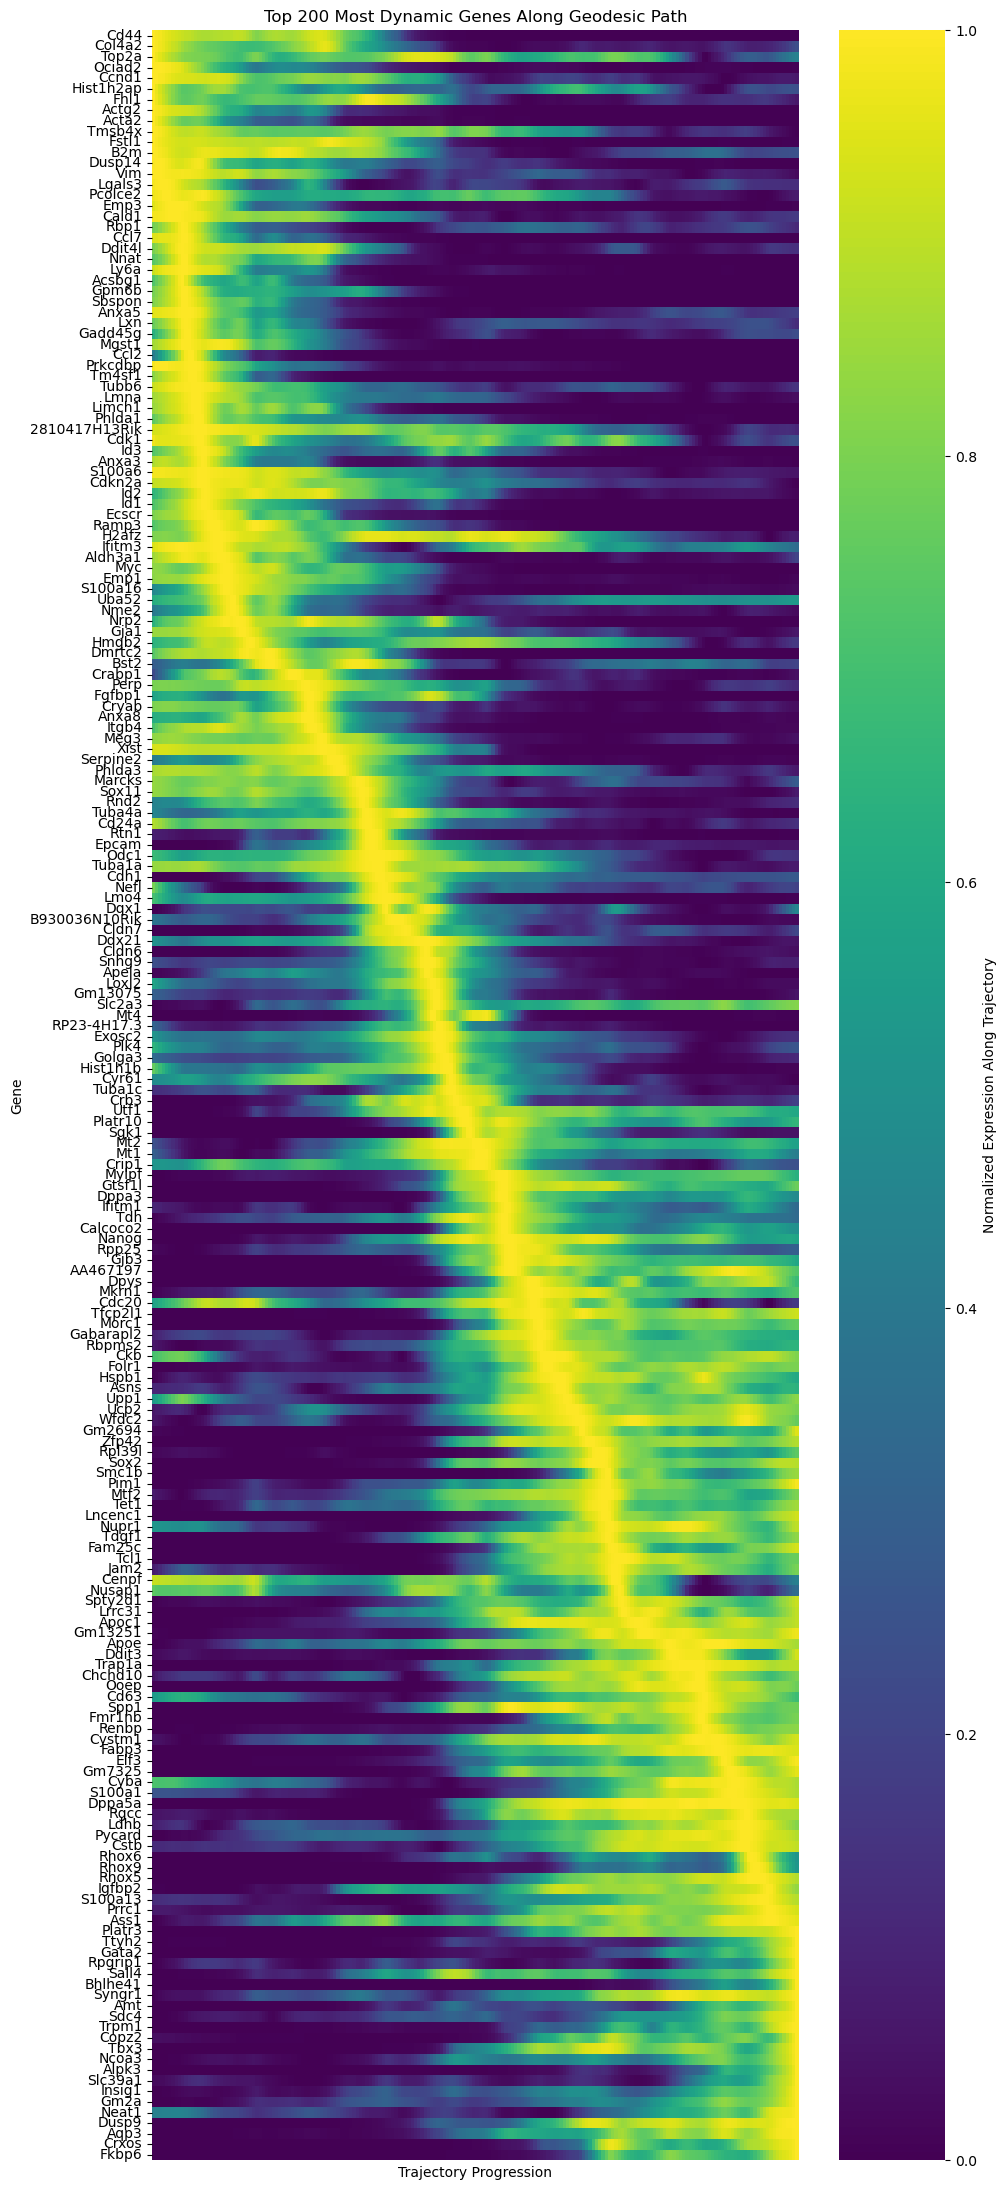

In [ ]:
import matplotlib.pyplot as plt
from Genodesic.Visualizers import (
    load_autoencoder_and_metadata,
    decode_latent_trajectory,
    find_dynamic_genes,
    plot_dynamic_genes_heatmap
)

# --- 1. Load Model and Gene Metadata ---
try:
    autoencoder_model, hvg_gene_names = load_autoencoder_and_metadata(
        ae_checkpoint_path=ae_model_save_path,
        hvg_tensor_path=hvg_tensor_path,
        device=DEVICE
    )
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure previous steps have run successfully. Details: {e}")
    raise

# --- 2. Decode Latent Path to Gene Expression ---
print("\n--- Decoding Latent Trajectory ---")
expression_curve = decode_latent_trajectory(
    autoencoder_model=autoencoder_model,
    latent_path=refined_path, # Assuming phi_relaxed is available from a previous cell
    device=DEVICE
)
print(f"Decoded path to an expression curve of shape {expression_curve.shape}")

# --- 3. Find and Order Dynamic Genes ---
print("\n--- Identifying Dynamic Genes ---")
ordered_expression_data, ordered_gene_names = find_dynamic_genes(
    expression_curve=expression_curve,
    gene_names=hvg_gene_names,
    num_genes=200 
)

# --- 4. Plot Heatmap ---
print("\n--- Plotting Heatmap ---")
plot_dynamic_genes_heatmap(
    expression_data=ordered_expression_data,
    gene_names=ordered_gene_names,
    figsize=(10, 22)
)